### Applying Grad-CAM to Clouds Classification Model

* based on https://github.com/jacobgil/pytorch-grad-cam

In [38]:
from os import path
import pandas as pd
import numpy as np

import torch
from torch import nn
import torchvision.transforms as T
# the pretrained net we're using
from torchvision.models import efficientnet_b2

from pytorch_lightning import LightningModule

import cv2
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import (show_cam_on_image,
                                          deprocess_image,
                                          preprocess_image)

import matplotlib.pyplot as plt

%matplotlib inline

In [26]:
# Globals

# size of the image we're working on (EffNet B2)
IMAGE_SIDE = 260

# for normalization of image
MEANS = [0.485, 0.456, 0.406]
STDS = [0.229, 0.224, 0.225]

# number of differents classes of Clouds
CLASS_NAMES = ["cirriform clouds", "high cumuliform clouds", 
                "stratocumulus clouds", "cumulus clouds", 
                "cumulonimbus clouds", "stratiform clouds", 
                "clear sky"]
N_CLASSES = len(CLASS_NAMES)

# the base_dir inside which we unzip the file from Kaggle
BASE_DIR = "/home/datascience/clouds_classification_data/"

IMAGES_TRAIN = path.join(BASE_DIR, "images/train/")
IMAGES_TEST = path.join(BASE_DIR, "images/test/")

# the file with image_name, label
FILE_TRAIN = path.join(BASE_DIR, "train.csv")

MODEL_FILE = "./checkpoint_clouds/bestb206022023.ckpt"

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [27]:
#
# Some parts have been removed, not needed for inference
#
class LitCloudClassifierB2(LightningModule):
    def __init__(self, learning_rate=0.0001):

        super().__init__()

        # Set our init args as class attributes
        self.lr = learning_rate

        # dataset specific attributes
        self.num_classes = N_CLASSES
        
        # Define PyTorch model: a simple CNN
        self.model = efficientnet_b2(pretrained=True)
        # changed to 1408 for B2
        self.model.classifier[1] = nn.Sequential(nn.Linear(1408, self.num_classes, bias=True))

    def forward(self, x):
        # the model outputs logits not probabilities
        # this is better for numerical stability
        x = self.model(x)
        return F.log_softmax(x, dim=1)

def get_val_transform():
    return T.Compose(
        [
            T.Resize((IMAGE_SIDE, IMAGE_SIDE)),
            T.ToTensor(), 
            T.Normalize(mean=MEANS, std=STDS)
        ]
    )

#### Reload the Model from a checkpoint

In [28]:
model_lt = LitCloudClassifierB2.load_from_checkpoint(MODEL_FILE)

# the inner PyTorch model (EffNet B2)
model = model_lt.model
# move on GPU
model = model.to(DEVICE)

In [29]:
#
# Let's choose the layer on which apply GradCam
# model.features is eìverything before avgpool
# and the final classifier
# -1 is the last conv layer, -2 the second to last and so on

#### This function compute and plot the Grad-CAM

In [30]:
def compute_and_plot_cam(img_path):
    img = np.array(Image.open(img_path))
    
    # resize and normalize the image
    img = cv2.resize(img, (IMAGE_SIDE, IMAGE_SIDE))
    img = np.float32(img) / 255
    # Imagenet mean and std
    input_tensor = preprocess_image(img, mean=MEANS, std=STDS)
    # move in gpu
    input_tensor = input_tensor.to(DEVICE)
    
    # None means compute gradients for the class target
    # If targets is None, the highest scoring category
    # will be used for every image
    targets = None
    # choose the layers where you compute and avg gradients
    # I have chosen the last two from bottom
    target_layers = [model.features[-2], 
                     model.features[-1]]

    with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    
    # prepare output for plotting
    # crea lo stack orizz. di due immagini (orig, heatmap on top of orig)
    images = np.hstack((np.uint8(255*img), cam_image))
    result_images = Image.fromarray(images)
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(result_images)
    plt.tight_layout()

def show_for_class(orig_df, class_num):
    condition = (orig_df['label'] == class_num)

    sel_df = orig_df.loc[condition]
    
    display(sel_df.head())
    
def get_label_path(index):
    label = label_list [INDEX]
    id_name = id_list[INDEX]
    path_name = path.join(IMAGES_TRAIN, id_name)
    
    return label, id_name, path_name

def predict(path_name):
    img = Image.open(path_name)
    # normalize and get tensor
    img = get_val_transform()(img)
    
    # addebatch dimension
    img_batch = img.unsqueeze(0)
    img_batch = img_batch.to(DEVICE)
    
    preds = model(img_batch)

    class_predicted = torch.argmax(preds)
    class_predicted = class_predicted.item()
    
    return class_predicted

#### Choose images

In [31]:
file_train_df = pd.read_csv(FILE_TRAIN)

id_list = file_train_df['id'].values
label_list = file_train_df['label'].values

file_train_df.head()

,id,label
0,f164dae2e2cdd4e5411e93a8dc95d142.jpg,3
1,588083bc2555da85c1db7e8abd9d6922.jpg,1
2,dd20037db2aa28f7b617bbf5f6754470.jpg,2
3,a6d1c3b86279c54afd4e2fdf0b88111a.jpg,2
4,8989be70528a5ff4cfa6d098afb5722e.jpg,1


#### Search Cumuli Nimbus (Normally are signs of bad weather conditions)

In [32]:
show_for_class(file_train_df, 4)

,id,label
59,ee0351d96022afb52a510a052ea8ed9a.jpg,4
85,c2340cdc7d40d5ad33927e9be8383954.jpg,4
173,d9a4ff29050f733af3dcb492822cc4b2.jpg,4
184,eee8b0808eeed3b64c45a471436a7630.jpg,4
185,ebc7b36b0cdb8efdca3a7101903be714.jpg,4


Image path: c2340cdc7d40d5ad33927e9be8383954.jpg
Label is: 4 (cumulonimbus clouds), Class predicted is: 4



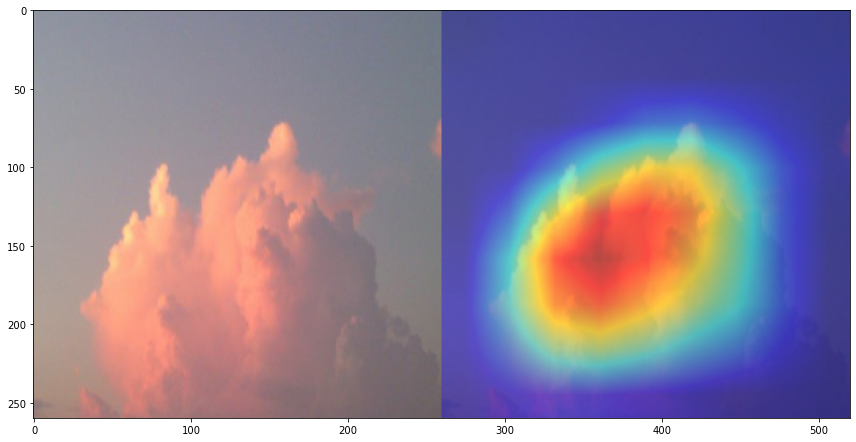

In [14]:
INDEX = 85

label, id_name, path_name = get_label_path(INDEX)

class_predicted = predict(path_name)

print(f"Image path: {id_name}")
print(f"Label is: {label} ({CLASS_NAMES[label]}), Class predicted is: {class_predicted}")
print()

compute_and_plot_cam(path_name)

#### Cirrus

In [34]:
show_for_class(file_train_df, 0)

,id,label
5,0208a6357f23cf53980f72dea42ade63.jpg,0
27,f0b2766599a642086166659726f9cd33.jpg,0
33,d973f08dbc803eb043d194d3437c14b7.jpg,0
36,340555680976ad462eae36ec7ca31ec4.jpg,0
52,d6ab11f3a8d89776f0ec24463b720b1c.jpg,0


Image path: 0208a6357f23cf53980f72dea42ade63.jpg
Label is: 0 (cirriform clouds), Class predicted is: 0



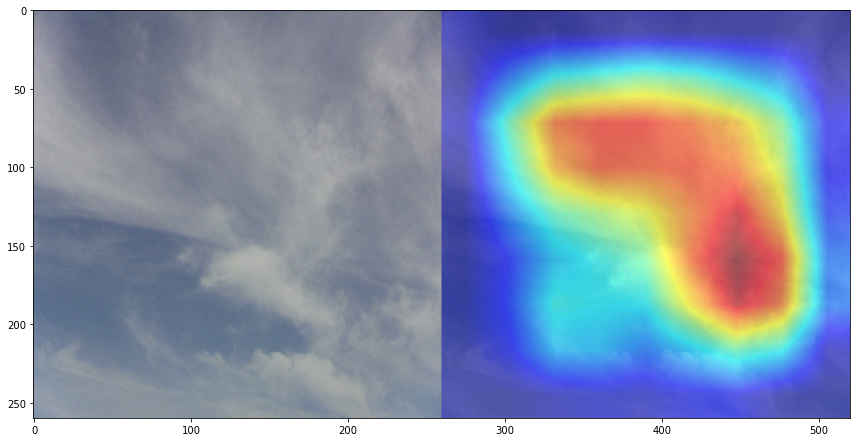

In [35]:
INDEX = 5

label, id_name, path_name = get_label_path(INDEX)

class_predicted = predict(path_name)

print(f"Image path: {id_name}")
print(f"Label is: {label} ({CLASS_NAMES[label]}), Class predicted is: {class_predicted}")
print()

compute_and_plot_cam(path_name)

#### Search for Clear Sky

In [36]:
show_for_class(file_train_df, 6)

,id,label
10,ad11a969db9f8efc117590e65ae05e40.jpg,6
24,a01efd0145ef021e532176e148493c84.jpg,6
47,926365bffee41128d65a127cad1c16f0.jpg,6
66,d62f12cd4887df22a3a0ba174ce33572.jpg,6
68,dcdc999b9205ea0931831ea3d4b07a9a.jpg,6


Image path: ad11a969db9f8efc117590e65ae05e40.jpg
Label is: 6 (clear sky), Class predicted is: 6



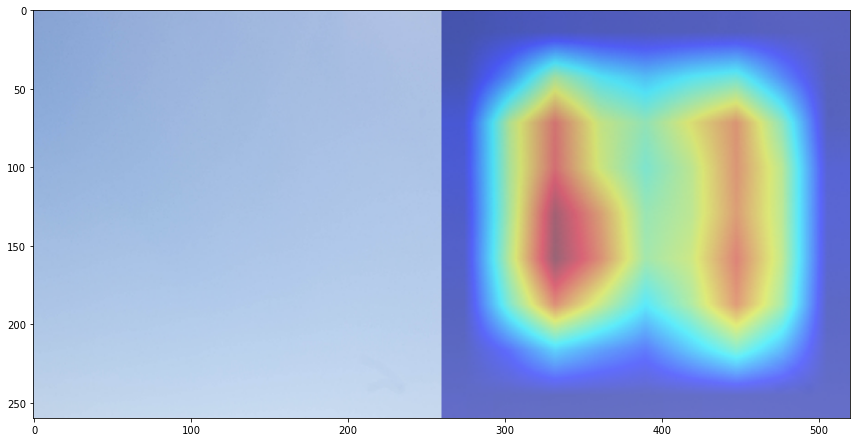

In [37]:
INDEX = 10

label, id_name, path_name = get_label_path(INDEX)

class_predicted = predict(path_name)

print(f"Image path: {id_name}")
print(f"Label is: {label} ({CLASS_NAMES[label]}), Class predicted is: {class_predicted}")
print()

compute_and_plot_cam(path_name)